## Лабараторная №4

Выканаў __Трафімаў Аляксандр__

-------

4.Вычисление и визуализация морфологического спектра

Разработать программу вычисления и визуализации морфологического спектра для бинарных и полутоновых изображений и различных структурирующих элементов.

Полутоновое изображение можно также взять из skimage.data (http://scikit-image.org/docs/dev/api/skimage.data.html?highlight=bool)

In [1]:
import skimage
from skimage import morphology as skmorph
from skimage.morphology import disk, diamond
from scipy.ndimage import morphology as ndmorph
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm as tqdm_nb

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['font.size'] = 13
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['figure.titlesize'] = 17

def show_images(images, titles=None, cols=3, width=7, height=7, to_show_axis=False):
    rows = len(images) // cols + (1 if len(images) % cols > 0 else 0)
    fig, ax = plt.subplots(
        rows, cols, figsize=(width * cols, height * rows), squeeze=False)
    ax_flatten = ax.flatten()
    
    if titles is not None:
        if not len(images) == len(titles):
            raise ValueError('images and title must have the same len')
    
    for i in range(len(images)):
        ax_flatten[i].imshow(images[i]);
        if not to_show_axis: ax_flatten[i].axis('off')
        if titles is not None: ax_flatten[i].set_title(titles[i])
    for i in range(len(images), len(ax_flatten)):
        ax_flatten[i].set_visible(False)
    fig.tight_layout()
    fig.subplots_adjust(top=(0.85 if titles is not None else 0.95))
    return fig, ax


def unpad_image(padded, initial_shape):
    dy = (padded.shape[0] - initial_shape[0]) // 2
    dx = (padded.shape[1] - initial_shape[1]) // 2
    return padded[dy:-dy, dx:-dx]


def show_partial_images(partial_list, to_unpad=True, initial_shape=None, stride=3, **kwargs):
    if to_unpad == True and initial_shape is None:
        raise ValueError('must provide initial shape to unpad')
    func = lambda x: (unpad_image(x, initial_shape=initial_shape) if to_unpad else x)
    show_images(
        [func(partial_list[i][1]) for i in range(0, len(partial_list), stride)], 
        titles=[partial_list[i][0] for i in range(0, len(partial_list), stride)], 
        **kwargs);

## create binary image

init binary shape: (250, 250). new shape: (750, 750)


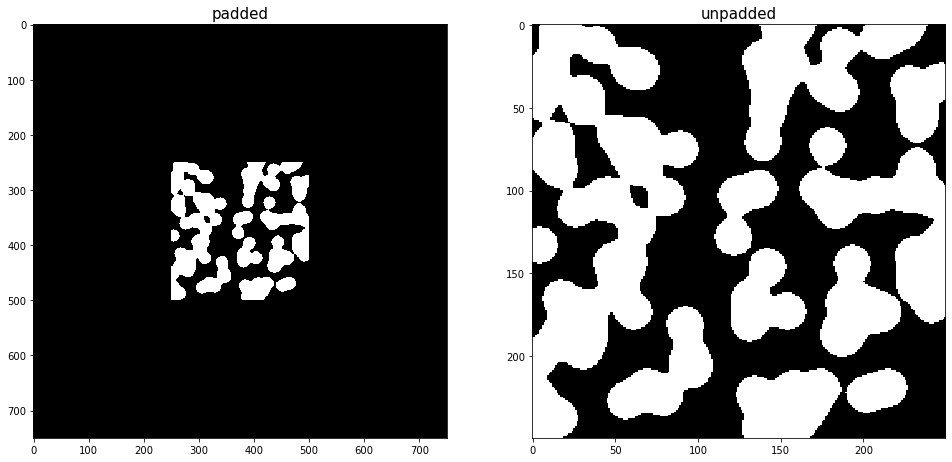

In [2]:
# pad for correct erosions with large structural element

sz = 250
image_bin = skimage.data.binary_blobs(sz, blob_size_fraction=.1, volume_fraction=.5, seed=1)
init_shape_bin = image_bin.shape
image_bin = np.pad(image_bin, sz)
print(f'init binary shape: {init_shape_bin}. new shape: {image_bin.shape}')
show_images([image_bin, unpad_image(image_bin, init_shape_bin)], titles=['padded', 'unpadded'], to_show_axis=True, cols=2);

In [3]:
selem = disk

## morphological spectrum for binary image

In [4]:
def get_pos_spectrum_part_for_binary_image(image, selem, max_iters=150):
    n = 0
    prev = image.copy()
    partial_opened = []
    differences = []
    pos_a = []

    with tqdm_nb(total=max_iters) as pbar:
        while np.sum(prev) > 0 and n < max_iters:
            opened = ndmorph.binary_opening(image, selem(n + 1))
            diff = np.logical_xor(opened, prev)
            square = np.sum(diff)
            pos_a.append((n, square))
            partial_opened.append((n, opened))
            differences.append((n, diff))
            prev = opened
            n += 1
            pbar.update()
        if n < max_iters:
            pbar.update(max_iters - n)
    print(f'total number of iterations: {n}')
    
    return pos_a, partial_opened, differences

In [5]:
pos_a, partial_opened, differences = get_pos_spectrum_part_for_binary_image(image_bin, selem)


total number of iterations: 20


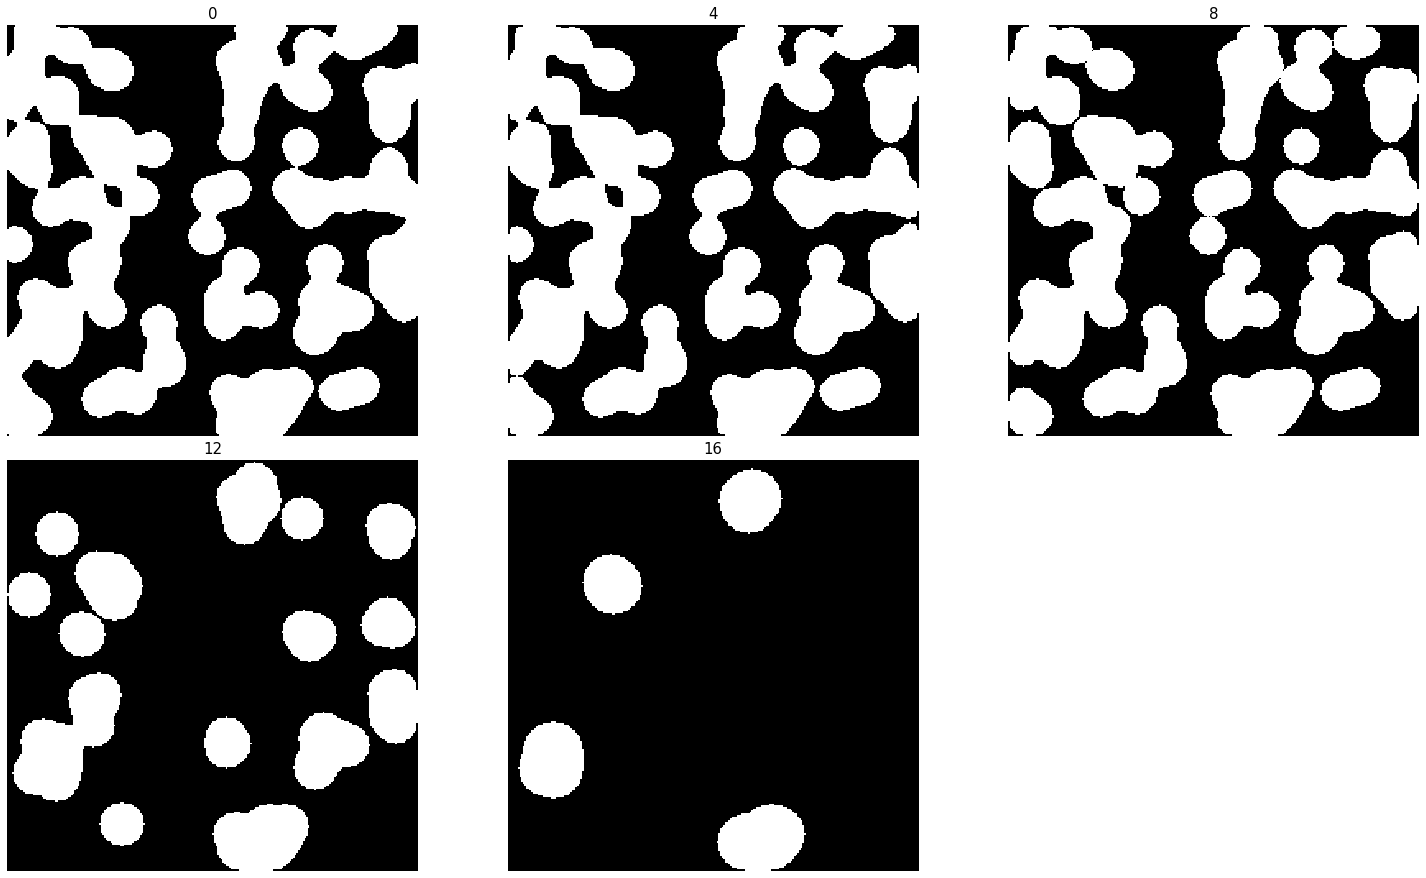

In [6]:
show_partial_images(partial_opened, initial_shape=init_shape_bin, stride=4)

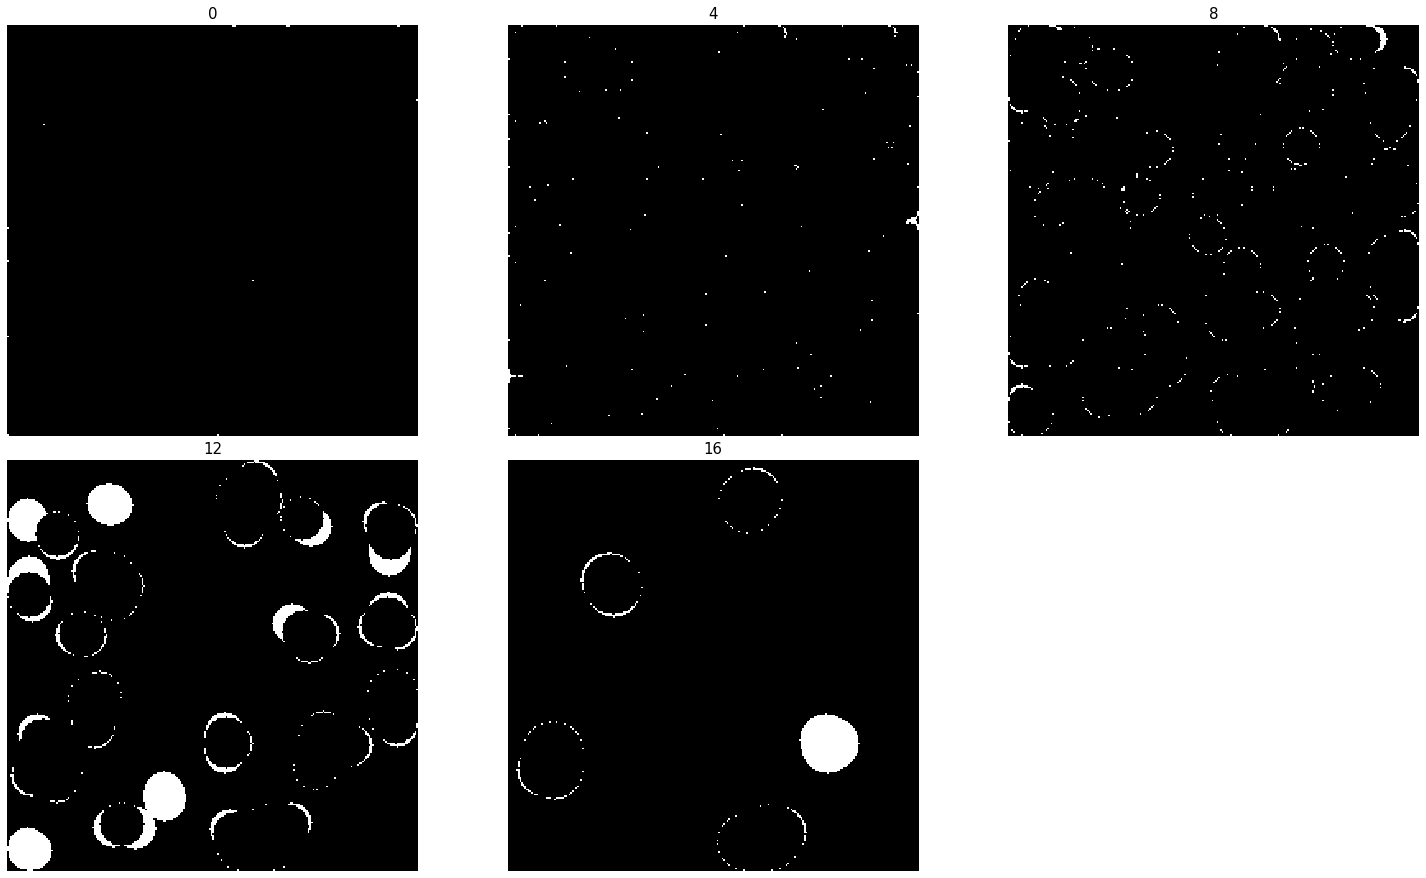

In [7]:
show_partial_images(differences, initial_shape=init_shape_bin, stride=4)

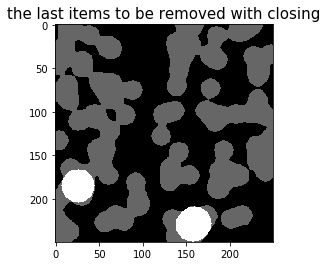

In [8]:
plt.title('the last items to be removed with closing')
plt.imshow(unpad_image(image_bin, init_shape_bin))
plt.imshow(unpad_image(partial_opened[-2][1], init_shape_bin), alpha=.6);

In [9]:
def get_neg_spectrum_part_for_binary_image(image, selem, max_iters=150):
    n = 0
    prev = image.copy()
    partial_closed = []
    differences = []
    neg_a = []

    with tqdm_nb(total = max_iters) as pbar:
        while n < max_iters:
            closed = ndmorph.binary_closing(image, selem(n + 1))
            if np.array_equal(prev, closed): 
                break
            diff = np.logical_xor(closed, prev)
            square = np.sum(diff)
            neg_a.append((-n - 1, square))
            partial_closed.append((n + 1, closed))
            differences.append((n + 1, diff))
            prev = closed
            n += 1
            pbar.update()
        if n < max_iters:
            pbar.update(max_iters - n)
        else:
            print(f'iterations limit exceeded: {max_iters}')
    print(f'total number of iterations: {n}')
    
    return neg_a, partial_closed, differences

In [10]:
neg_a, partial_closed, differences = get_neg_spectrum_part_for_binary_image(image_bin, selem)


total number of iterations: 35


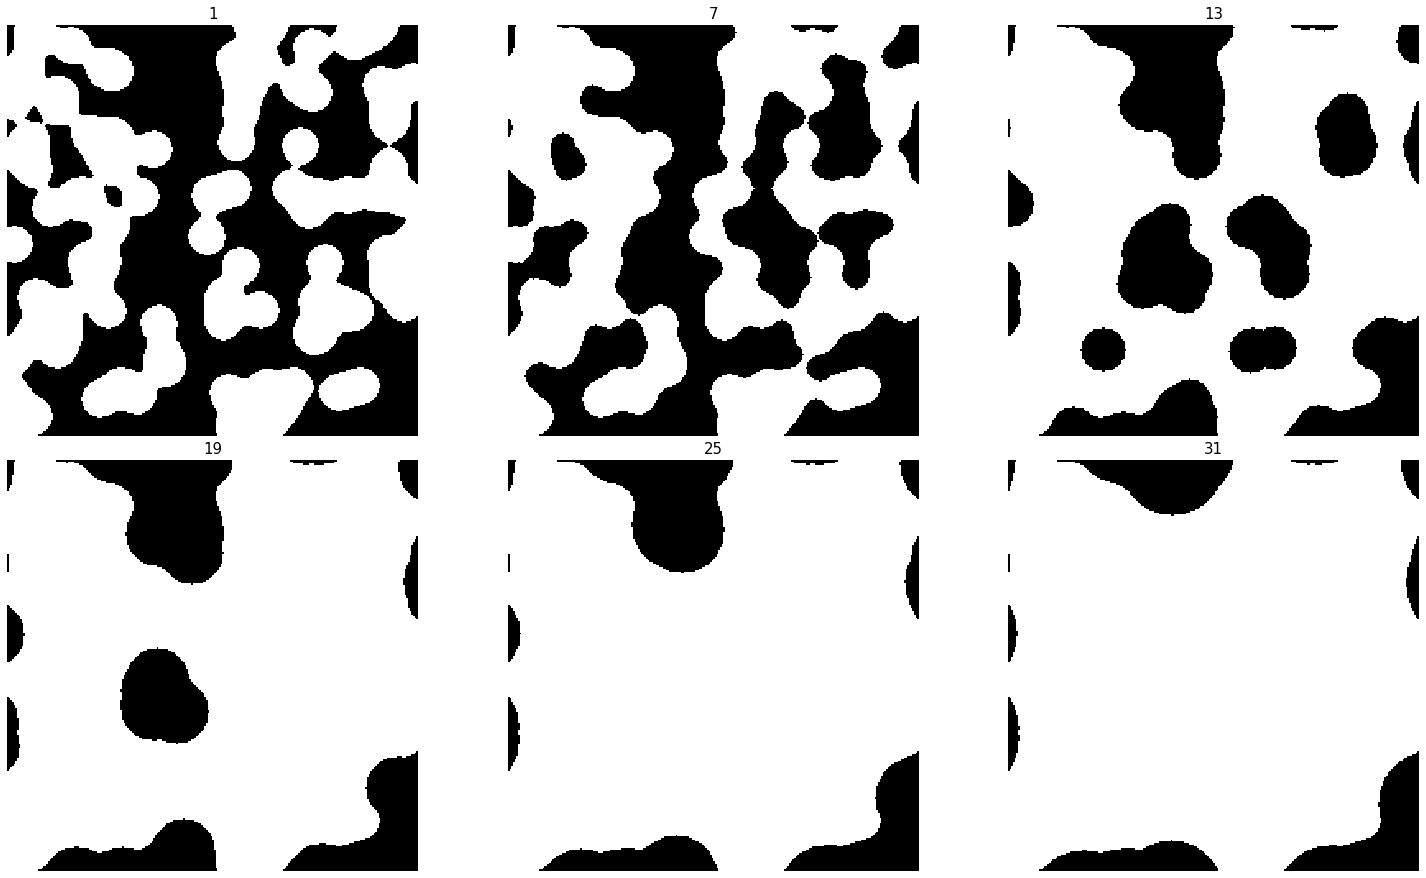

In [11]:
show_partial_images(partial_closed, initial_shape=init_shape_bin, stride=6, cols=3)

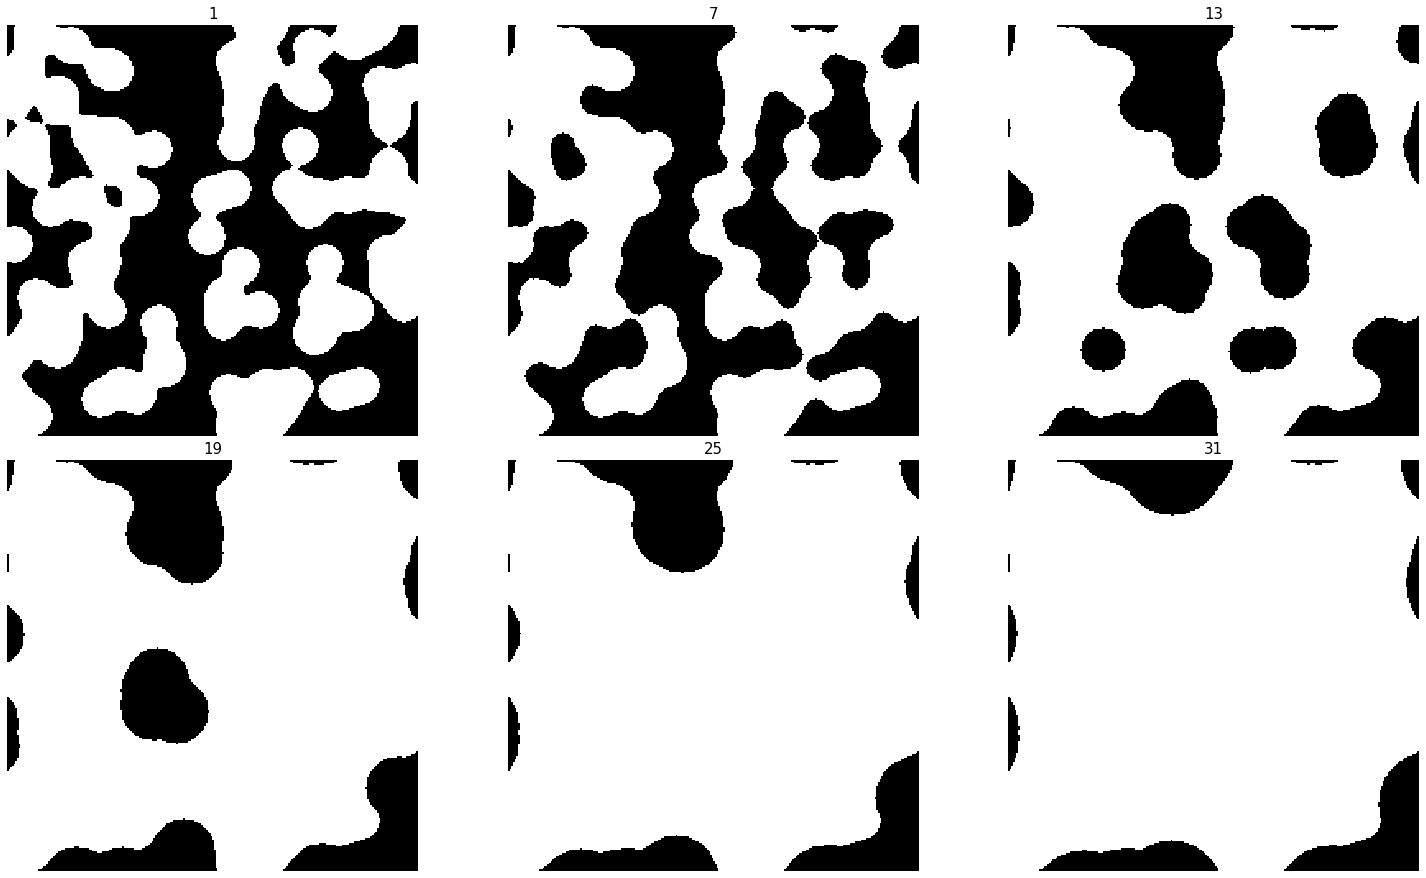

In [12]:
show_partial_images(partial_closed, initial_shape=init_shape_bin, stride=6, cols=3)

## plot the spectrum

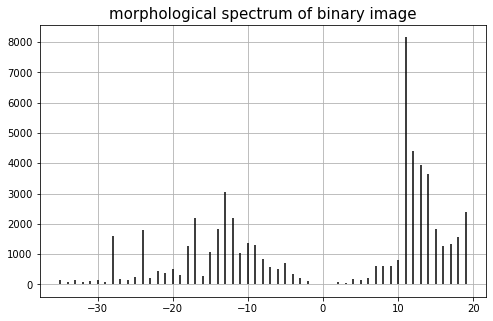

In [13]:
a = list(reversed(neg_a))
a.extend(pos_a)

plt.figure(figsize=(8, 5))
plt.vlines([x[0] for x in a], 0, [x[1] for x in a]);
plt.title('morphological spectrum of binary image')
plt.grid()

# morphological spectrum for grayscale image

## load grayscale images

init shape: (61, 77). new shape: (235, 251)


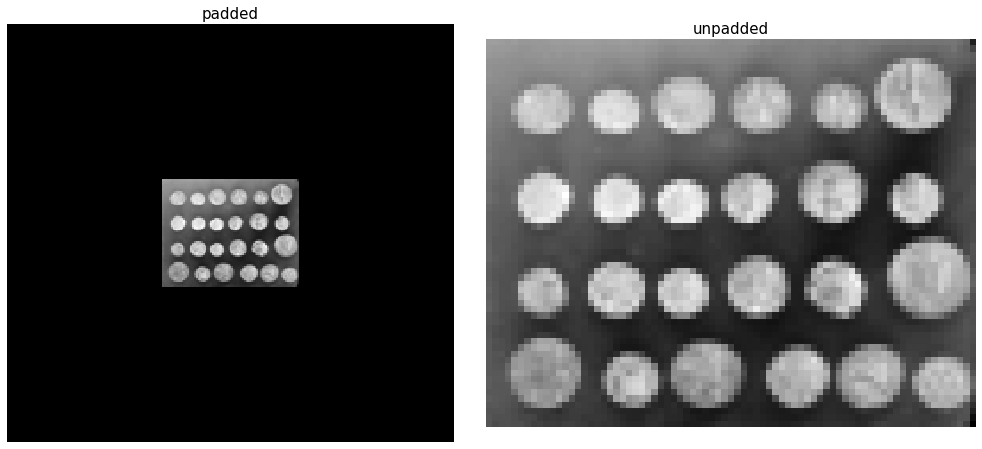

In [15]:
coins = skimage.data.coins()
image_grey = skimage.transform.rescale(
    coins, 0.2, preserve_range=True, anti_aliasing=True).astype(np.uint8)
init_shape_grey = image_grey.shape
delta = max(init_shape_grey) + 10
image_grey = np.pad(image_grey, delta)
print(f'init shape: {init_shape_grey}. new shape: {image_grey.shape}')
show_images([image_grey, unpad_image(image_grey, init_shape_grey)], titles=['padded', 'unpadded']);

In [16]:
selem = disk

In [17]:
def get_pos_spectrum_part_for_grey_image(image, selem, max_iters=150):
    n = 0
    prev = image.copy()
    pos_a = []
    partial_opened = []
    diffs_opening = []

    with tqdm_nb(total=max_iters) as pbar:
        while n < max_iters:
            opened = ndmorph.grey_opening(image, footprint=selem(n + 1))
            if np.sum(opened) == 0:
                pbar.update(max_iters - n)
                break
            partial_opened.append((n + 1, opened))
            diff = prev - opened
            diffs_opening.append((n + 1, diff))
            pos_a.append((n, np.sum(diff)))
            prev = opened
            n += 1
            pbar.update()
        else:
            print(f'exceeded max number of iterations: {max_iters}')
    
    print(f'total number of iterations: {n}')
    return pos_a, partial_opened, diffs_opening

In [18]:
pos_a_grey, partial_opened_grey, diffs_opening_grey = get_pos_spectrum_part_for_grey_image(image_grey, selem)


total number of iterations: 30


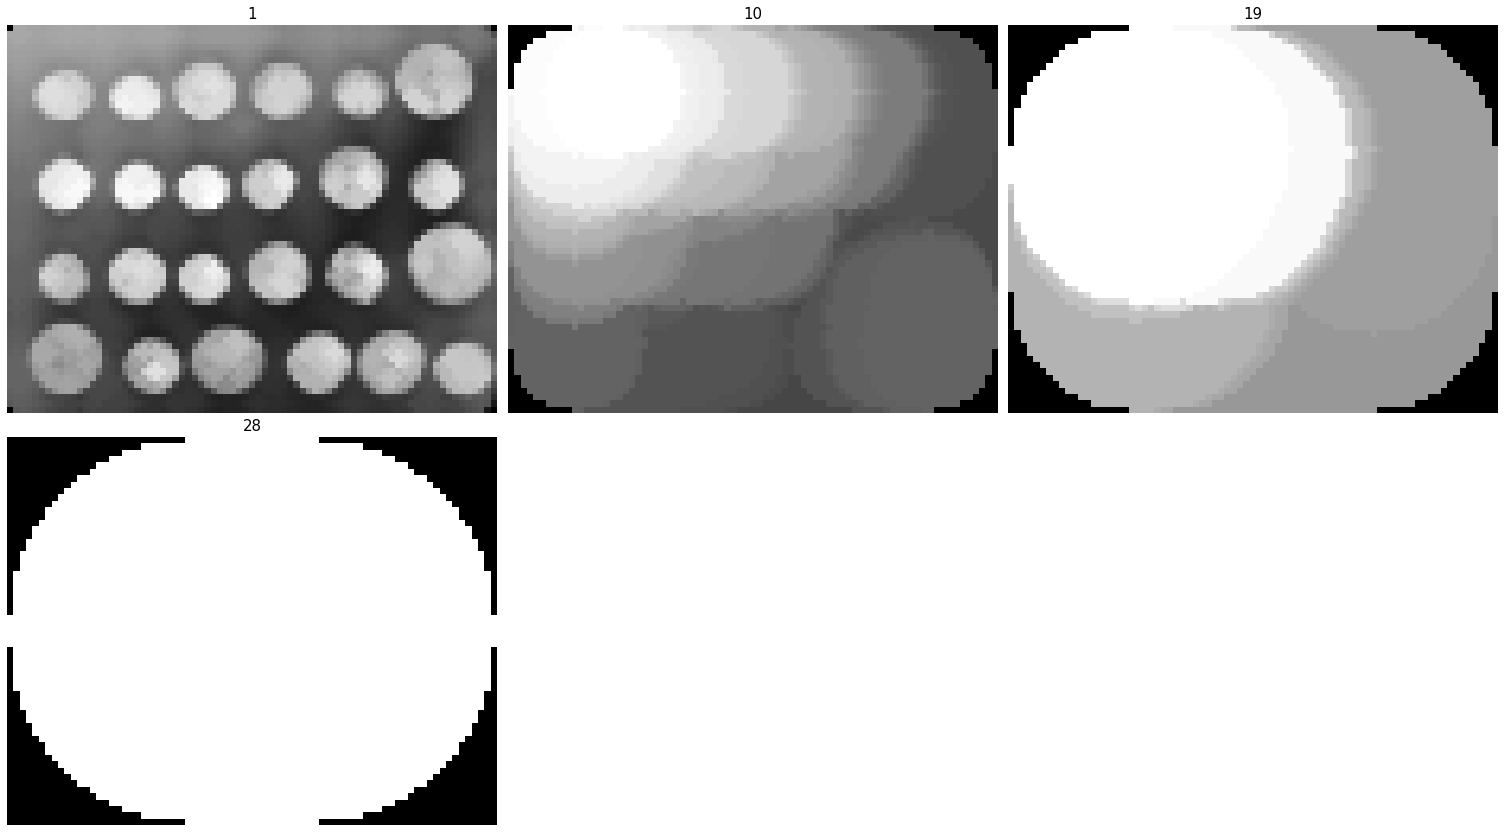

In [19]:
show_partial_images(partial_opened_grey, initial_shape=init_shape_grey, stride=9)

In [20]:
def get_neg_spectrum_part_for_grey_image(image, selem, max_iters=90):
    n = 0
    prev = image.copy()
    neg_a = []
    partial_closed = []
    diffs_closing = []

    with tqdm_nb(total=max_iters) as pbar:
        while n < max_iters:
            closed = ndmorph.grey_closing(image, footprint=selem(n + 1))
            diff = closed.astype(np.int) - prev.astype(np.int)
            if np.sum(diff) < 0:
                pbar.update(max_iters - n)
                break
            diff = diff[diff > 0]
            partial_closed.append((n + 1, closed))
            diffs_closing.append((n + 1, diff))
            neg_a.append((-n - 1, np.sum(diff)))
            prev = closed
            n += 1
            pbar.update()
        else:
            print(f'exceeded max number of iterations: {max_iters}')
    
    print(f'total number of iterations: {n}')
    return neg_a, partial_closed, diffs_closing

In [21]:
neg_a_grey, partial_closed_grey, diffs_closing_grey = get_neg_spectrum_part_for_grey_image(image_grey, selem)


total number of iterations: 36


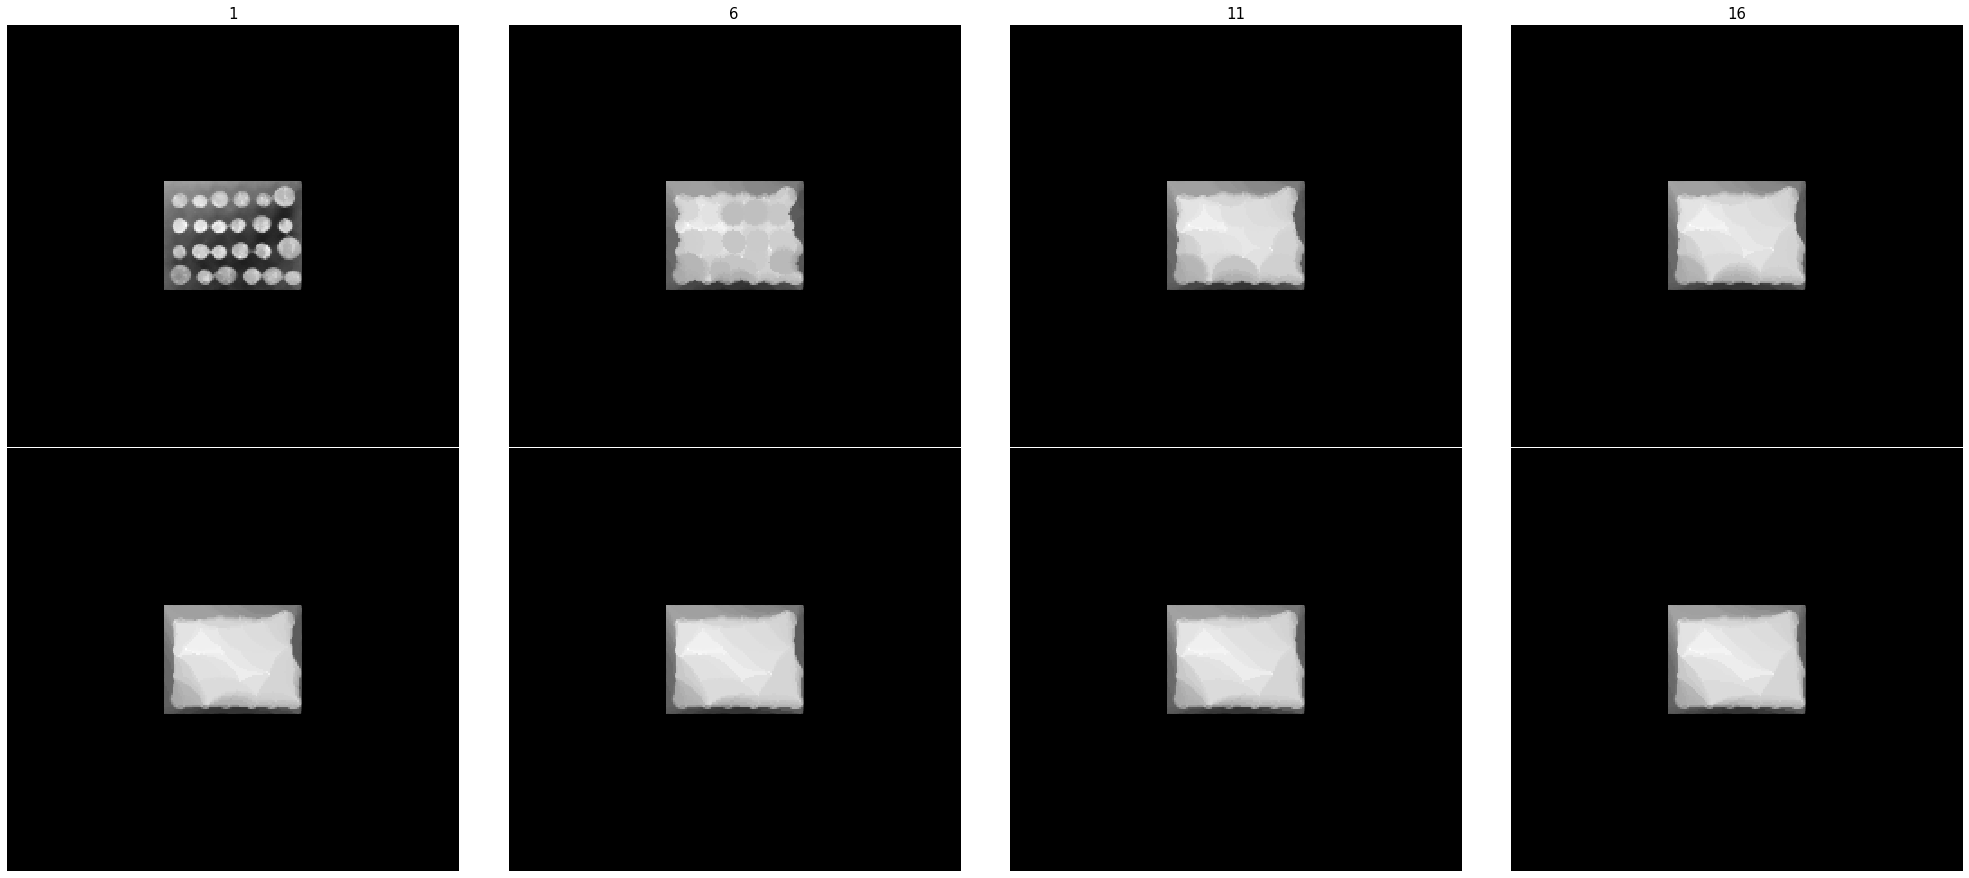

In [22]:
show_partial_images(partial_closed_grey, to_unpad=False, stride=5, cols=4)

## plot the spectrum

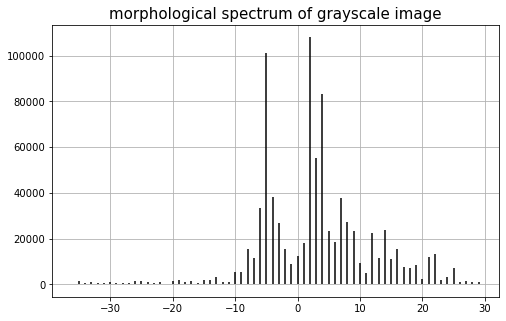

In [23]:
a = list(reversed(neg_a_grey))
a.extend(pos_a_grey)

plt.figure(figsize=(8, 5))
plt.vlines([x[0] for x in a], 0, [x[1] for x in a]);
plt.title('morphological spectrum of grayscale image')
plt.grid()